In [40]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

In [25]:
%matplotlib inline

Loading the data

In [26]:
# load data
df = pd.read_csv('New_Delhi_reviews.csv')
df.dropna(inplace = True)
df.columns

Index(['rating_review', 'review_full'], dtype='object')

<AxesSubplot:ylabel='rating_review'>

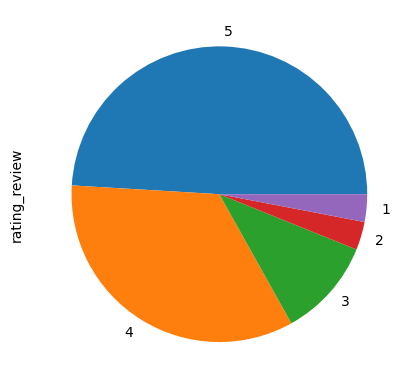

In [27]:
df['rating_review'].value_counts().plot(kind='pie')

Preprocessing

In [31]:
# cleaning the data
stopwords = nltk.corpus.stopwords.words('english')
punctuation = r'[/.!$%^&#*+\'\"()-.,:;<=>?@[\]{}|]'

In [32]:
def clean_text(text):
    """
    Clean text
    :parameters:
        text: sentence (string)
    :return: preprocessed documents without punctuations and stopwords, and lowercased
    """
    pp_text = re.sub(punctuation, ' ', text)
    pp_text = pp_text.lower()
    pp_text = ' '.join([w for w in pp_text.split() if len(w) > 1 and w not in stopwords])
    return pp_text

In [33]:
df['pp_text'] = df['review_full'].apply(clean_text)

Getting sentences, labels, and generating embeddings

In [34]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
reviews = df['pp_text'].to_list()
ratings = df['rating_review'].to_list()

# encoding sentences
embeddings = model.encode(reviews)

Training and testing classifier: SVM

In [36]:
# inbalanced data: stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, ratings,
                                                    stratify=ratings, 
                                                    test_size=0.2)

In [37]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)

LinearSVC(random_state=0, tol=1e-05)

In [38]:
y_predicted = model.predict(X_test)

In [41]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.56      0.60      0.58       891
           2       0.10      0.00      0.00       910
           3       0.49      0.23      0.32      3187
           4       0.51      0.49      0.50     10050
           5       0.67      0.81      0.73     14478

    accuracy                           0.61     29516
   macro avg       0.47      0.43      0.43     29516
weighted avg       0.58      0.61      0.58     29516



In [42]:
print('Confusion Matrix:')
res = confusion_matrix(y_test, y_predicted)
print(res)

Confusion Matrix:
[[  539     3   153   102    94]
 [  213     1   281   267   148]
 [  139     3   743  1630   672]
 [   44     1   250  4940  4815]
 [   19     2    77  2689 11691]]


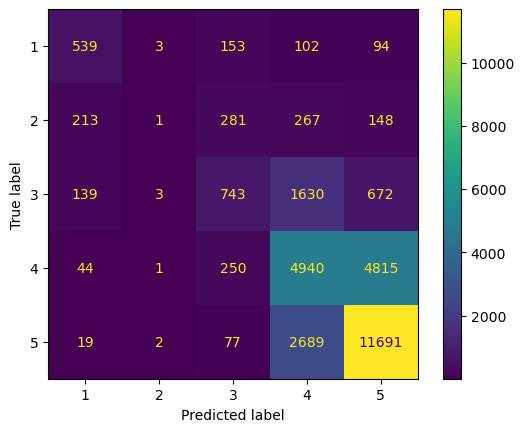

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
plt.show()

We can try to use over and under sampling techniques to balance the original dataset:

              precision    recall  f1-score   support

           1       0.37      0.69      0.48       891
           2       0.17      0.37      0.23       910
           3       0.34      0.40      0.37      3187
           4       0.53      0.43      0.47     10050
           5       0.73      0.69      0.71     14478

    accuracy                           0.56     29516
   macro avg       0.43      0.52      0.45     29516
weighted avg       0.59      0.56      0.57     29516



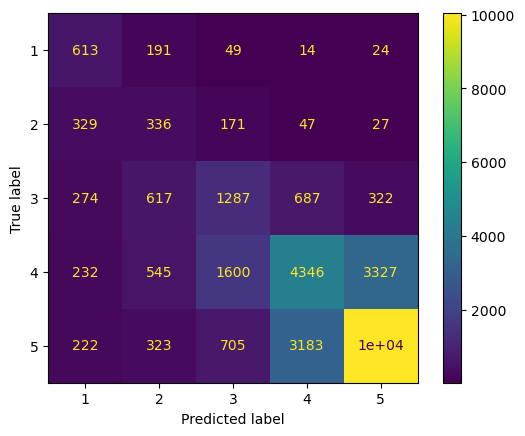

In [44]:
# trying SMOTE for over sampling
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(embeddings, ratings,
                                                    stratify=ratings, 
                                                    test_size=0.2)

RANDOM_STATE = 42
ros = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
plt.show()

Using an over sampling technique (SMOTE) the performance for the minority classes, 1 and 2, improved. On the other hand, the performance for class 5 has worsened.